# Neural Network

Here we implement our own simple neural network using the numerical computing library NumPy. NumPy is the de facto standard library for computing in Python. [Here](https://numpy.org/) you can find a well maintained documentation of NumPy library.

**Note:** While NumPy is highly optimized, it does not provide practical tools specifically aimed for machine learning and robot learning. There is number of machine learning frameworks like Tensorflow, PyTorch, JAX and many more, providing useful tools and deploying computation from a single core CPU on your computer to GPUs and clusters of computing units. Tensor multiplication can be performed a multitude faster on the GPU than the CPU.

Evolution as black-box approach can optimize all kinds of problems. However, it has been shown, that the combination of neural networks a general function approximators with evolutionary algorithms can solve complex problems.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Multilayer Perceptron (MLP)

In the following, we will implement a fully connected feed-forward neural network also called Multilayer Perceptron. Every neurons receives inputs from all the neurons in the previous layers and provides outputs to the subsequent layer.

### Activation functions

To enable universal function approximation, we need to introduce non-linearity to our neural network. For that, we use a non-linear activation function. In the following, we implement two activation functions: `hidden_activation_fcn` and `output_activation_fcn`. There is a large repertoire of activation functions possible. In robot learning, one commong choice is the `tanh`-function and the `sigmoid`-function. We use the sigmoid activation here for the hidden layer activation:

\begin{align} 
\text{sigmoid }(x) = \frac{1}{1 + e^{-x}} 
\end{align}

In [2]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

Let us plot your function.

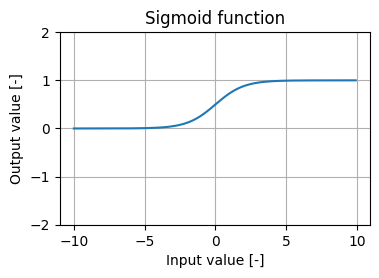

In [3]:
# Sample data for plotting
x = np.arange(-10.0, 10.0, 0.1)
y = sigmoid(x)

fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(x, y)

ax.set(xlabel='Input value [-]', ylabel='Output value [-]', ylim=(-2, 2),
       title='Sigmoid function')
ax.grid()

# plt.show()

For the output-function in this exercise, we choose the tangens hyperbolicus. `tanh` is a typical output function for continuous actionspaces as it also garantues that our output is between -1 and 1. 
\begin{align} 
\tanh{x} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
\end{align}

In [4]:
def tanh(x):
    y = np.tanh(x)
    return y

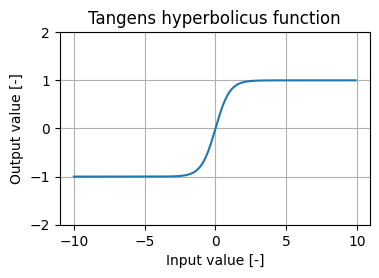

In [5]:
# Sample data for plotting
x = np.arange(-10.0, 10.0, 0.1)
y = tanh(x)

fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(x, y)

ax.set(xlabel='Input value [-]', ylabel='Output value [-]', ylim=(-2, 2),
       title='Tangens hyperbolicus function')
ax.grid()

# plt.show()

In [6]:
def identity(x):
    y = x
    return y

For discrete action spaces, the `softmax`-function is the most common choice. It returns the gradient of the log of the sum of exponentials of input elements which relates to the probability of an action.  

> **Reference:** P. Blanchard, D.J. Higham, N.J. Higham, “Accurately computing the log-sum-exp and softmax functions”, IMA Journal of Numerical Analysis, Vol.41(4), DOI:10.1093/imanum/draa038.

In [7]:
def softmax(x):
    y = np.exp(x)/sum(np.exp(x))
    return y

## Neurons
Current neural networks consist out of layers of neurons. Neurons consist out of a simple linear functions with the weight defining the slope and an additive bias term. This is illustrated in the following plot.

<img src="perceptron.svg" width="350">
    
Based on this, we can deduct a mathematical equation:

\begin{align}
y_i = \sum_{i=1}^{n} w_i \cdot x_i + b_i \qquad \text{with} \quad i = 1, 2, ... , n_{\text{neurons}}
\end{align}

Afterwards, we apply our activation function to generate non-linear signals:

\begin{align}
    o_i = f_{activation}(y_i)
\end{align}

## Layers
Fully-connected neural networks are layered. So each layer is defined by a number of neurons. Every layer receives an input and generates an output to the next layer. Computing every neuron individually is inefficient for large neural networks. For a more efficient computation, we can vectorize the layers of our neural network.

\begin{align}
\mathbf{y} = W \mathbf{x} + \mathbf{b} 
\end{align}

where y is a vector of the output of every neuron of a layer, x is the vectorized input to each layer, W is a matrix mapping the each weight and each input to each neuron of a layer and b is a bias vector. 

In [8]:
class MLP:
    def __init__(self, n_inputs, n_hidden_1, n_hidden_2, n_outputs):
        self.hidden_layer_1 = np.random.uniform(size=(n_hidden_1, n_inputs))
        self.hidden_layer_2 = np.random.uniform(size=(n_hidden_2, n_hidden_1))
        self.hidden_layer_3 = np.random.uniform(size=(n_outputs, n_hidden_2))
        
        self.bias_1 = np.random.uniform(size=(n_hidden_1))
        self.bias_2 = np.random.uniform(size=(n_hidden_2))
        self.bias_3 = np.random.uniform(size=(n_outputs))
        
    def forward(self, inputs):
        # Reshape inputs
        inputs = np.reshape(inputs, (-1, 1))
        
        # @-operator is equivalent to np.dot
        out_1 =  self.hidden_layer_1 @ inputs + self.bias_1.reshape(-1, 1) 
        out_1 = identity(out_1)
        
        out_2 = self.hidden_layer_2 @ out_1 + self.bias_2.reshape(-1, 1) 
        out_2 = identity(out_2)
        
        out_3 = self.hidden_layer_3 @ out_2 + self.bias_3.reshape(-1, 1) 
        out_3 = identity(out_3)
  
        outputs = np.tanh(out_3)
        outputs = np.transpose(outputs)[0]
        return outputs
        
    def flatten_params(self):
        # Flatten weights and biases
        flat_weights = np.concatenate([self.hidden_layer_1.flatten(), 
                                       self.hidden_layer_2.flatten(), 
                                       self.hidden_layer_3.flatten()])

        flat_biases = np.concatenate([self.bias_1.flatten(), 
                                      self.bias_2.flatten(), 
                                      self.bias_3.flatten()])

        # Concatenate all flattened parameters
        return np.concatenate([flat_weights, flat_biases])

    def unflatten_params(self, flat_params):
        # Calculate total number of weights and biases
        weights_length = (self.hidden_layer_1.size + 
                          self.hidden_layer_2.size + 
                          self.hidden_layer_3.size)

        # Extract flattened weights and biases
        flat_weights = flat_params[:weights_length]
        flat_biases = flat_params[weights_length:]

        # Reshape weights to original dimensions
        self.hidden_layer_1 = flat_weights[:self.hidden_layer_1.size].reshape(self.hidden_layer_1.shape)
        offset = self.hidden_layer_1.size
        self.hidden_layer_2 = flat_weights[offset:offset + self.hidden_layer_2.size].reshape(self.hidden_layer_2.shape)
        offset += self.hidden_layer_2.size
        self.hidden_layer_3 = flat_weights[offset:offset + self.hidden_layer_3.size].reshape(self.hidden_layer_3.shape)

        # Reshape biases to original dimensions
        self.bias_1 = flat_biases[:self.bias_1.size].reshape(self.bias_1.shape)
        offset = self.bias_1.size
        self.bias_2 = flat_biases[offset:offset + self.bias_2.size].reshape(self.bias_2.shape)
        offset += self.bias_2.size
        self.bias_3 = flat_biases[offset:offset + self.bias_3.size].reshape(self.bias_3.shape)

        

In [9]:
nn = MLP(24, 16, 8, 4)

### Forward-pass

In [10]:
# Test forward pass
input_size = 24
hidden_1_size = 16
hidden_2_size = 4
output_size = 4

# Initialise neural network
nn = MLP(input_size, hidden_1_size, hidden_2_size, output_size)

# Randomly generate input vector from uniform distribution
observation = np.random.uniform(size=(input_size,))

action = nn.forward(observation)
print(f"Observation:\n{observation}\n\nAction:\n{action}")

Observation:
[0.37784694 0.70592095 0.73886285 0.54043656 0.23290356 0.05844076
 0.31300793 0.95529393 0.55870311 0.55592195 0.4907128  0.1664113
 0.35853901 0.52751912 0.72797095 0.20364653 0.49152633 0.69014501
 0.31446098 0.22112457 0.29736814 0.22110905 0.52287428 0.84308126]

Action:
[1. 1. 1. 1.]


### Flattening
The neural network consists now out of multiple layers with neurons. To run evolution, we need a flattened representation, where we can optimize our parameters. For that, we implemented a flatten function. After the optimization step, we need to unflatten the parameters again and feed it back to the nested layered neural network structure.

In [11]:
nn = MLP(24, 16, 8, 4)

# Test if flatten and unflatten work
params_before = nn.hidden_layer_2

flat_params = nn.flatten_params()
nn.unflatten_params(flat_params)

params_after = nn.hidden_layer_2

assert np.allclose(params_before, params_after)